In [1]:
#!/usr/bin/env python3
#pip install  rioxarray==0.3.1
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray
import numpy as np
import geopandas as gpd
import cartopy.crs as ccrs
import rasterio
import os
import matplotlib.colors
scriptsdir = os.getcwd()
from scipy.interpolate import griddata
from functools import reduce
import xarray
import itertools
import matplotlib.colors as mcolors
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import warnings
from shapely.geometry import box


In [2]:
models = ["GAM"]
taxas = ["Mammals"]
time=[35]
model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
years = ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050','2052', '2056', '2080', '2100', '2150', '2200', '2250']


In [18]:
###append habitats
directory = "/storage/homefs/ch21o450/scripts/BioScenComb/habitat_counts/"
pattern= 'habitat_*_*_*_GAM_35.csv'

matching_files = [
    filename for filename in os.listdir(directory)
    if filename.startswith('habitat_')
    and filename.endswith('GAM_35.csv')
    and 'habitat_forest' in filename
]


# Print the matching file names
for filename in matching_files:
    print(filename)
import glob

df_forest = pd.DataFrame()

for file in matching_files:
    df=pd.read_csv(directory +file)
    df_forest = df_forest.append(df, ignore_index=True)
    
df_forest.to_csv(f'/storage/homefs/ch21o450/scripts/BioScenComb/habitat_counts/df_forest_GAM_35.csv', index=False)
df_forest
 

habitat_forest_Amphibians_GAM_35.csv
habitat_forest_Mammals_GAM_35.csv
habitat_forest_Bird_GAM_35.csv


,Species
0,Hyloscirtus_palmeri
1,Rhinella_dapsilis
2,Smilisca_phaeota
3,Scinax_cardosoi
4,Amolops_larutensis
...,...
2245,Phyllastrephus_cerviniventris
2246,Accipiter_trinotatus
2247,Hirundo_leucosoma
2248,Orthogonys_chloricterus


In [19]:
###append habitats
directory = "/storage/homefs/ch21o450/scripts/BioScenComb/habitat_counts/"
pattern= 'habitat_*_*_*_GAM_35.csv'

matching_files = [
    filename for filename in os.listdir(directory)
    if filename.startswith('habitat_')
    and filename.endswith('GAM_35.csv')
    and 'habitat_forest' not in filename
]


df_nonforest = pd.DataFrame()

for file in matching_files:
    print(file)
    df=pd.read_csv(directory +file)
    df_nonforest = df_nonforest.append(df, ignore_index=True)
    
df_nonforest.to_csv(f'/storage/homefs/ch21o450/scripts/BioScenComb/habitat_counts/df_nonforest_GAM_35.csv', index=False)
 
 

habitat_natural_land_Amphibians_GAM_35.csv
habitat_natural_land_Mammals_GAM_35.csv
habitat_pasture_Mammals_GAM_35.csv
habitat_pasture_Bird_GAM_35.csv
habitat_pasture_Amphibians_GAM_35.csv
habitat_cropland_Bird_GAM_35.csv
habitat_natural_land_Bird_GAM_35.csv
habitat_cropland_Mammals_GAM_35.csv
habitat_cropland_Amphibians_GAM_35.csv


In [23]:
df

,Species
0,Hyloscirtus_palmeri
1,Rhinella_dapsilis
2,Smilisca_phaeota
3,Scinax_cardosoi
4,Amolops_larutensis
...,...
2245,Phyllastrephus_cerviniventris
2246,Accipiter_trinotatus
2247,Hirundo_leucosoma
2248,Orthogonys_chloricterus


In [ ]:
matching_files

In [43]:
models=["GAM"]
taxas=["Mammals","Amphibians","Bird"]


model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
years = ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050',
         '2052', '2056', '2080', '2100', '2150', '2200', '2250']

for taxa in taxas:
    for model in models:
        df = pd.read_csv('/storage/homefs/ch21o450/scripts/BioScenComb/habitat_counts/habitat_forest_' + taxa + '_' + model + '_35.csv')
        species_list = df['Species'].tolist()  # Replace with the actual column name
        species_names = species_list[:10]



    def newvalue_fun(time, model, netcdf_path_format, is_historical=False, scenario=None):
        newvalue_dict = {model_name: {} for model_name in model_names}
        sum_bin_dict = {model_name: {} for model_name in model_names}

        for model_name in model_names:
            for species_name in species_names:
                if is_historical:
                    ds = xr.open_dataset(netcdf_path_format.format(model, taxa, species_name, time), decode_times=False)
                else:
                    ds = xr.open_dataset(netcdf_path_format.format(model, taxa, model_name, scenario, species_name, time), decode_times=False)

                newvalue = ds["newvalue"]
                sum_bin = ds["sum_bin"]

                newvalue_dict[model_name][species_name] = newvalue
                sum_bin_dict[model_name][species_name] = sum_bin

        projections_dict = {}

        for species_name in species_names:
            value_list = []
            for model_name in model_names:
                value_bin = newvalue_dict[model_name][species_name]
                #value_bin = value_bin.where(value_bin > 0, 1)
                #value_bin = (value_bin > 0.00)

                value_list.append(value_bin)
            value_bin_concat = xr.concat(value_list, dim="model_name")
            mean_value_bin = value_bin_concat.mean(dim="model_name")
            projections_dict[species_name] = mean_value_bin

        value_bin_list = list(projections_dict.values())
        mean_value_bin = xr.concat(value_bin_list, dim="species").sum(dim="species")  # Ensemble mean over species
        mean_value_bin = mean_value_bin.where(mean_value_bin > 0, 0)
        return mean_value_bin

    def calculate_mean(time, model, netcdf_path_format, is_historical=False, scenario=None):
        newvalue_dict = {model_name: {} for model_name in model_names}
        sum_bin_dict = {model_name: {} for model_name in model_names}
        lu_sum_bin_dict = {model_name: {} for model_name in model_names}

        for model_name in model_names:
            for species_name in species_names:
                if is_historical:
                    ds = xr.open_dataset(netcdf_path_format.format(model, taxa, species_name, time), decode_times=False)
                else:
                    ds = xr.open_dataset(netcdf_path_format.format(model, taxa, model_name, scenario, species_name, time), decode_times=False)
                sum_bin = ds["sum_bin"]
                #lu_sum_bin = ds["sum_lu_binary"]
                #sum_bin = (sum_bin > 0.00)

                sum_bin_dict[model_name][species_name] = sum_bin
                #lu_sum_bin_dict[model_name][species_name] = lu_sum_bin

        projections_dict = {}

        for species_name in species_names:
            sum_bin_list = []
            for model_name in model_names:
                sum_bin = sum_bin_dict[model_name][species_name]
                sum_bin_list.append(sum_bin)
            sum_bin_concat = xr.concat(sum_bin_list, dim="model_name")
            mean_sum_bin = sum_bin_concat.mean(dim="model_name")
            projections_dict[species_name] = mean_sum_bin

        mean_sum_bin_list = list(projections_dict.values())
        mean_sum_bin = xr.concat(mean_sum_bin_list, dim="species").sum(dim="species")  # Ensemble mean over species
        mean_sum_bin = mean_sum_bin.where(mean_sum_bin > 0, 0)

        return mean_sum_bin

    historical_time = 1146
    future_times = [35, 65]
   # scenarios = ["rcp26"]

    netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/{}/{}/{}_[{}].nc"
    netcdf_path_format_hist = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/EWEMBI/{}_[{}].nc"

    mean_value_bin_hist = newvalue_fun(historical_time, model, netcdf_path_format_hist, is_historical=True)
    mean_sum_bin_hist = calculate_mean(historical_time, model, netcdf_path_format_hist, is_historical=True)

    mean_sum_bin_hist = mean_sum_bin_hist.isel(time=0)

    year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

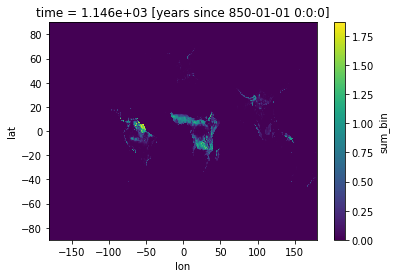

In [45]:
mean_sum_bin_hist.plot()

In [29]:

historical_time = 1146
future_times = [35, 65]
# scenarios = ["rcp26"]

netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/{}/{}/{}_[{}].nc"
netcdf_path_format_hist = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/EWEMBI/{}_[{}].nc"

mean_value_bin_hist = newvalue_fun(historical_time, model, netcdf_path_format_hist, is_historical=True)
mean_sum_bin_hist = calculate_mean(historical_time, model, netcdf_path_format_hist, is_historical=True)

mean_sum_bin_hist = mean_sum_bin_hist.isel(time=0)

year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

NameError: name 'newvalue_fun' is not defined

## Mammals GAM 35 species habitat count

In [ ]:
a

In [16]:
#count the habitats in LUH2 categories per taxa separate
years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050','2052', '2056', '2080', '2100', '2150', '2200', '2250']
year_indices = {35: 9, 65: 12, 85: 13}
selected_year = years[year_indices[time[0]]]
if time[0] == 35 or time[0] == 65:
    GCMs = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    bioscen_GCMs = ['GFDL.ESM2M', 'IPSL.CM5A-LR', 'HadGEM2.ES', 'MIROC5']
    scenarios = ["rcp26","rcp60"]
    ssprcps_shorts = ["ssp126","ssp460"]
elif time[0] == 85:
    GCMs = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    bioscen_GCMs = ['IPSL.CM5A-LR', 'HadGEM2.ES', 'MIROC5']
    scenarios = ["rcp26"]
    ssprcps_shorts = ["ssp126"]
    
species_habitat_counts = {}



for taxa in taxas:   
    for model in models:
        for bioscen_GCM in bioscen_GCMs: 
            for scenario in scenarios: 
                convcodes = pd.read_csv("/storage/homefs/ch21o450/scripts/BioScenComb/data/IUCN_LUH_converion_table_Carlson.csv")
                dir_habclass = "/storage/homefs/ch21o450/IUCN/Habitat_Classifications/" + taxa + "/"
                dir_species = "/storage/workspaces/wa_climate/climate_trt/data/BioScen15/individual_projections/" + taxa+ "_" + model +"_results_climate/"
                available_file = os.listdir(dir_species)
                available_names = [x.split(".csv")[0] for x in available_file]

                formatted_names = []

                for species_name in available_names:
                    split_species_name = species_name.split("_")[:2]
                    formatted_species_name = " ".join(split_species_name)
                    formatted_names.append(formatted_species_name)

                for i, species_name in enumerate(formatted_names[:10]):
                    formatted_species_name = species_name.replace(" ", "_")
                    species_habitat_counts[formatted_species_name] = {f'LUH{i}': 0 for i in range(1,13)}


                    for file_name in available_file:
                        if formatted_species_name in file_name and model + '_dispersal.csv.xz' in file_name:
                            species_file = file_name
                            species_file2 = [x.split(".csv")[0] for x in species_file] 
                            break
                    else:
                        bioscen_species = None
                        continue

                    bioscen_species = pd.read_csv(dir_species + file_name)

                    available_files_iucn = formatted_species_name + ".csv"
                    if available_files_iucn in os.listdir(dir_habclass):
                        IUCN = pd.read_csv(dir_habclass + available_files_iucn)
                    else:
                        continue

                    lon = bioscen_species["x"]
                    lat = bioscen_species["y"]
                    z = bioscen_species[bioscen_GCM + '_' + scenario + '_' + selected_year]

                    df = pd.DataFrame({"lon": lon, "lat": lat, "vals": z})
                    df = df.fillna(0)

                    # Create a bounding box geometry for the desired extent
                    #extent = box(-168.022, 60.0, -105.0, 72.554)
                    extent = box(-180.0, -90.0, 180.0, 90.0)


                    # Check if there are values within the extent
                    if df[(df['lon'] >= extent.bounds[0]) & (df['lon'] <= extent.bounds[2]) &
                       (df['lat'] >= extent.bounds[1]) & (df['lat'] <= extent.bounds[3])].empty:
                        # No values within the extent, end the code
                        print("No values within the specified extent.")
                    else:

                        convcodes_renamed = convcodes.rename(columns={'IUCN_hab':'result.code'})
                        IUCN['result.code'] = pd.to_numeric(IUCN['result.code'], errors='coerce')
                        Habitats = IUCN.merge(convcodes_renamed, left_on='result.code', right_on='result.code')

                        keys = ['LUH1', 'LUH2', 'LUH3', 'LUH4', 'LUH5', 'LUH6', 'LUH7', 'LUH8','LUH9','LUH10', 'LUH11', 'LUH12']
                        split_cols = Habitats['LUH'].str.split('.', expand=True)
                        for i, key in enumerate(keys):
                            if i < len(split_cols.columns):
                                Habitats[key] = split_cols[i]
                            else:
                                Habitats[key] = pd.Series(dtype='float64')
                        if len(Habitats.columns) > len(keys) + 1:
                            num_missing_cols = len(Habitats.columns) - len(keys) - 1
                            Habitats = Habitats.reindex(columns=list(Habitats.columns) + ['LUH{}'.format(i) for i in range(13, 13 + num_missing_cols)], fill_value=np.nan)
                        Habitats_suitable = Habitats[Habitats['result.suitability'] == 'Suitable'].copy()


                        for i in range(1, 13):  # Assuming you have up to LUH20
                            habitat_key = f'LUH{i}'

                            # Check if not all values are NaN
                            if not Habitats_suitable[habitat_key].isnull().all():
                                # Get the unique habitat classes in the column
                                habitats = Habitats_suitable[habitat_key].dropna().unique()

                                # Increment the count for each habitat class
                                for habitat in habitats:
                                    if habitat not in species_habitat_counts[formatted_species_name]:
                                        species_habitat_counts[formatted_species_name][habitat] = 0
                                    species_habitat_counts[formatted_species_name][habitat] += 1
                                    
                        # Initialize a dictionary to hold the counts per category
                        category_counts = {}

                        # Iterate over each species' habitat counts
                        for species, counts in species_habitat_counts.items():
                            # Create a set to track unique habitats for the current species
                            unique_habitats = set()

                            # Iterate over each habitat count for the species
                            for habitat, count in counts.items():
                                # Check if the habitat starts with 'LUH' and the count is non-zero
                                if not habitat.startswith('LUH') and count > 0:
                                    # Add the habitat to the set
                                    unique_habitats.add(habitat)
                                    # Check if the habitat is already in the dictionary
                                    if habitat not in category_counts:
                                        category_counts[habitat] = 0
                                    # Increment the count for the habitat category
                                    category_counts[habitat] += 1

                       # print(category_counts)


{'primn': 1, 'secdn': 1}
{'primn': 2, 'secdn': 2}
{'primn': 2, 'secdn': 2, 'primf': 1, 'secdf': 1}
{'primn': 2, 'secdn': 2, 'primf': 2, 'secdf': 2}
{'primn': 2, 'secdn': 2, 'primf': 3, 'secdf': 3}
{'primn': 3, 'secdn': 3, 'primf': 4, 'secdf': 4}
{'primn': 4, 'secdn': 4, 'primf': 5, 'secdf': 5}
{'primn': 4, 'secdn': 4, 'primf': 6, 'secdf': 6}
{'primn': 5, 'secdn': 5, 'primf': 7, 'secdf': 7}
{'primn': 6, 'secdn': 6, 'primf': 7, 'secdf': 7}
{'primn': 6, 'secdn': 6, 'primf': 7, 'secdf': 7}
{'primn': 6, 'secdn': 6, 'primf': 7, 'secdf': 7}
{'primn': 6, 'secdn': 6, 'primf': 7, 'secdf': 7}
{'primn': 6, 'secdn': 6, 'primf': 7, 'secdf': 7}
{'primn': 6, 'secdn': 6, 'primf': 7, 'secdf': 7}
{'primn': 6, 'secdn': 6, 'primf': 7, 'secdf': 7}
{'primn': 6, 'secdn': 6, 'primf': 7, 'secdf': 7}
{'primn': 6, 'secdn': 6, 'primf': 7, 'secdf': 7}
{'primn': 6, 'secdn': 6, 'primf': 7, 'secdf': 7}
{'primn': 6, 'secdn': 6, 'primf': 7, 'secdf': 7}
{'primn': 6, 'secdn': 6, 'primf': 7, 'secdf': 7}
{'primn': 6, 'secdn

In [ ]:
#count the habitats in categories per taxa separate
taxas = ["Mammals"]
time=[35]


years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050','2052', '2056', '2080', '2100', '2150', '2200', '2250']
year_indices = {35: 9, 65: 12, 85: 13}
selected_year = years[year_indices[time[0]]]
if time[0] == 35 or time[0] == 65:
    GCMs = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    bioscen_GCMs = ['GFDL.ESM2M', 'IPSL.CM5A-LR', 'HadGEM2.ES', 'MIROC5']
    scenarios = ["rcp26","rcp60"]
    ssprcps_shorts = ["ssp126","ssp460"]
elif time[0] == 85:
    GCMs = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    bioscen_GCMs = ['IPSL.CM5A-LR', 'HadGEM2.ES', 'MIROC5']
    scenarios = ["rcp26"]
    ssprcps_shorts = ["ssp126"]
    
species_habitat_counts = {}
category_mapping = {
    'cropland': ['c3ann', 'c3per', 'c4ann', 'c4per', 'c3nfx'],
    'pasture': ['pastr', 'range'],
    'forest': ['primf', 'secdf'],
    'natural_land': ['primn', 'secdn']
}



for taxa in taxas:   
    for model in models:
        for bioscen_GCM in bioscen_GCMs: 
            for scenario in scenarios: 
                convcodes = pd.read_csv("/storage/homefs/ch21o450/scripts/BioScenComb/data/IUCN_LUH_converion_table_Carlson.csv")
                dir_habclass = "/storage/homefs/ch21o450/IUCN/Habitat_Classifications/" + taxa + "/"
                dir_species = "/storage/workspaces/wa_climate/climate_trt/data/BioScen15/individual_projections/" + taxa+ "_" + model +"_results_climate/"
                available_file = os.listdir(dir_species)
                available_names = [x.split(".csv")[0] for x in available_file]

                formatted_names = []

                for species_name in available_names:
                    split_species_name = species_name.split("_")[:2]
                    formatted_species_name = " ".join(split_species_name)
                    formatted_names.append(formatted_species_name)

                for i, species_name in enumerate(formatted_names):
                    formatted_species_name = species_name.replace(" ", "_")
                    species_habitat_counts[formatted_species_name] = {f'LUH{i}': 0 for i in range(1,13)}


                    for file_name in available_file:
                        if formatted_species_name in file_name and model + '_dispersal.csv.xz' in file_name:
                            species_file = file_name
                            species_file2 = [x.split(".csv")[0] for x in species_file] 
                            break
                    else:
                        bioscen_species = None
                        continue

                    bioscen_species = pd.read_csv(dir_species + file_name)

                    available_files_iucn = formatted_species_name + ".csv"
                    if available_files_iucn in os.listdir(dir_habclass):
                        IUCN = pd.read_csv(dir_habclass + available_files_iucn)
                    else:
                        continue

                    lon = bioscen_species["x"]
                    lat = bioscen_species["y"]
                    z = bioscen_species[bioscen_GCM + '_' + scenario + '_' + selected_year]

                    df = pd.DataFrame({"lon": lon, "lat": lat, "vals": z})
                    df = df.fillna(0)

                    # Create a bounding box geometry for the desired extent
                    #extent = box(-168.022, 60.0, -105.0, 72.554)
                    extent = box(-180.0, -90.0, 180.0, 90.0)


                    # Check if there are values within the extent
                    if df[(df['lon'] >= extent.bounds[0]) & (df['lon'] <= extent.bounds[2]) &
                       (df['lat'] >= extent.bounds[1]) & (df['lat'] <= extent.bounds[3])].empty:
                        # No values within the extent, end the code
                        print("No values within the specified extent.")
                    else:

                        convcodes_renamed = convcodes.rename(columns={'IUCN_hab':'result.code'})
                        IUCN['result.code'] = pd.to_numeric(IUCN['result.code'], errors='coerce')
                        Habitats = IUCN.merge(convcodes_renamed, left_on='result.code', right_on='result.code')

                        keys = ['LUH1', 'LUH2', 'LUH3', 'LUH4', 'LUH5', 'LUH6', 'LUH7', 'LUH8','LUH9','LUH10', 'LUH11', 'LUH12']
                        split_cols = Habitats['LUH'].str.split('.', expand=True)
                        for i, key in enumerate(keys):
                            if i < len(split_cols.columns):
                                Habitats[key] = split_cols[i]
                            else:
                                Habitats[key] = pd.Series(dtype='float64')
                        if len(Habitats.columns) > len(keys) + 1:
                            num_missing_cols = len(Habitats.columns) - len(keys) - 1
                            Habitats = Habitats.reindex(columns=list(Habitats.columns) + ['LUH{}'.format(i) for i in range(13, 13 + num_missing_cols)], fill_value=np.nan)
                        Habitats_suitable = Habitats[Habitats['result.suitability'] == 'Suitable'].copy()


                        for i in range(1, 13):  # Assuming you have up to LUH20
                            habitat_key = f'LUH{i}'

                            # Check if not all values are NaN
                            if not Habitats_suitable[habitat_key].isnull().all():
                                # Get the unique habitat classes in the column
                                habitats = Habitats_suitable[habitat_key].dropna().unique()

                                # Increment the count for each habitat class
                                for habitat in habitats:
                                    if habitat not in species_habitat_counts[formatted_species_name]:
                                        species_habitat_counts[formatted_species_name][habitat] = 0
                                    species_habitat_counts[formatted_species_name][habitat] += 1
                                    

                        category_counts = {}
                        species_counted = set()
                        # Iterate over each species' habitat counts
                        for species, counts in species_habitat_counts.items():
                            # Create a set to track unique categories for the current species
                            unique_categories = set()

                            # Iterate over each habitat count for the species
                            for habitat, count in counts.items():
                                # Check if the habitat belongs to any category in the mapping
                                for category, category_habitats in category_mapping.items():
                                    if habitat in category_habitats:
                                        unique_categories.add(category)
                                        break  # Break once a match is found

                            # Iterate over the unique categories for the species
                            for category in unique_categories:
                                # Check if the species has already been counted for this category

                                if category not in category_counts:
                                    category_counts[category] = 0
                                # Increment the count for the category
                                category_counts[category] += 1
                                # Add the species to the counted set
                                species_counted.add(species)

print(category_counts)
print(len(species_counted))
print(taxa)

In [2]:
#count the habitats in categories for all taxa and save in one df
models = ["GAM"]
taxas = ["Mammals","Amphibians"]
time=[35]


years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050','2052', '2056', '2080', '2100', '2150', '2200', '2250']
year_indices = {35: 9, 65: 12, 85: 13}
selected_year = years[year_indices[time[0]]]
if time[0] == 35 or time[0] == 65:
    GCMs = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    bioscen_GCMs = ['GFDL.ESM2M', 'IPSL.CM5A-LR', 'HadGEM2.ES', 'MIROC5']
    scenarios = ["rcp26","rcp60"]
    ssprcps_shorts = ["ssp126","ssp460"]
elif time[0] == 85:
    GCMs = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    bioscen_GCMs = ['IPSL.CM5A-LR', 'HadGEM2.ES', 'MIROC5']
    scenarios = ["rcp26"]
    ssprcps_shorts = ["ssp126"]
    
species_habitat_counts = {}
category_mapping = {
    'cropland': ['c3ann', 'c3per', 'c4ann', 'c4per', 'c3nfx'],
    'pasture': ['pastr', 'range'],
    'forest': ['primf', 'secdf'],
    'natural_land': ['primn', 'secdn']
}

category_dfs = {category: pd.DataFrame(columns=['Species']) for category in category_mapping}


for taxa in taxas:   
    for model in models:
        for bioscen_GCM in bioscen_GCMs: 
            for scenario in scenarios: 
                convcodes = pd.read_csv("/storage/homefs/ch21o450/scripts/BioScenComb/data/IUCN_LUH_converion_table_Carlson.csv")
                dir_habclass = "/storage/homefs/ch21o450/IUCN/Habitat_Classifications/" + taxa + "/"
                dir_species = "/storage/workspaces/wa_climate/climate_trt/data/BioScen15/individual_projections/" + taxa+ "_" + model +"_results_climate/"
                available_file = os.listdir(dir_species)
                available_names = [x.split(".csv")[0] for x in available_file]

                formatted_names = []

                for species_name in available_names:
                    split_species_name = species_name.split("_")[:2]
                    formatted_species_name = " ".join(split_species_name)
                    formatted_names.append(formatted_species_name)

                for i, species_name in enumerate(formatted_names[:10]):
                    formatted_species_name = species_name.replace(" ", "_")
                    species_habitat_counts[formatted_species_name] = {f'LUH{i}': 0 for i in range(1,13)}


                    for file_name in available_file:
                        if formatted_species_name in file_name and model + '_dispersal.csv.xz' in file_name:
                            species_file = file_name
                            species_file2 = [x.split(".csv")[0] for x in species_file] 
                            break
                    else:
                        bioscen_species = None
                        continue

                    bioscen_species = pd.read_csv(dir_species + file_name)

                    available_files_iucn = formatted_species_name + ".csv"
                    if available_files_iucn in os.listdir(dir_habclass):
                        IUCN = pd.read_csv(dir_habclass + available_files_iucn)
                    else:
                        continue

                    lon = bioscen_species["x"]
                    lat = bioscen_species["y"]
                    z = bioscen_species[bioscen_GCM + '_' + scenario + '_' + selected_year]

                    df = pd.DataFrame({"lon": lon, "lat": lat, "vals": z})
                    df = df.fillna(0)

                    # Create a bounding box geometry for the desired extent
                    #extent = box(-168.022, 60.0, -105.0, 72.554)
                    extent = box(-180.0, -90.0, 180.0, 90.0)


                    # Check if there are values within the extent
                    if df[(df['lon'] >= extent.bounds[0]) & (df['lon'] <= extent.bounds[2]) &
                       (df['lat'] >= extent.bounds[1]) & (df['lat'] <= extent.bounds[3])].empty:
                        # No values within the extent, end the code
                        print("No values within the specified extent.")
                    else:

                        convcodes_renamed = convcodes.rename(columns={'IUCN_hab':'result.code'})
                        IUCN['result.code'] = pd.to_numeric(IUCN['result.code'], errors='coerce')
                        Habitats = IUCN.merge(convcodes_renamed, left_on='result.code', right_on='result.code')

                        keys = ['LUH1', 'LUH2', 'LUH3', 'LUH4', 'LUH5', 'LUH6', 'LUH7', 'LUH8','LUH9','LUH10', 'LUH11', 'LUH12']
                        split_cols = Habitats['LUH'].str.split('.', expand=True)
                        for i, key in enumerate(keys):
                            if i < len(split_cols.columns):
                                Habitats[key] = split_cols[i]
                            else:
                                Habitats[key] = pd.Series(dtype='float64')
                        if len(Habitats.columns) > len(keys) + 1:
                            num_missing_cols = len(Habitats.columns) - len(keys) - 1
                            Habitats = Habitats.reindex(columns=list(Habitats.columns) + ['LUH{}'.format(i) for i in range(13, 13 + num_missing_cols)], fill_value=np.nan)
                        Habitats_suitable = Habitats[Habitats['result.suitability'] == 'Suitable'].copy()


                        for i in range(1, 13):  # Assuming you have up to LUH20
                            habitat_key = f'LUH{i}'

                            # Check if not all values are NaN
                            if not Habitats_suitable[habitat_key].isnull().all():
                                # Get the unique habitat classes in the column
                                habitats = Habitats_suitable[habitat_key].dropna().unique()

                                # Increment the count for each habitat class
                                for habitat in habitats:
                                    if habitat not in species_habitat_counts[formatted_species_name]:
                                        species_habitat_counts[formatted_species_name][habitat] = 0
                                    species_habitat_counts[formatted_species_name][habitat] += 1
                                    

                        category_counts = {}
                        species_counted = set()
                        # Iterate over each species' habitat counts
                        # Create a set to keep track of processed species
                        processed_species = set()

                        # Inside the loop where you categorize species and add them to dataframes
                        for species, counts in species_habitat_counts.items():
                            # Check if the species has already been processed
                            if species in processed_species:
                                continue

                            # Create a set to track unique categories for the current species
                            unique_categories = set()

                            # Iterate over each habitat count for the species
                            for habitat, count in counts.items():
                                # Check if the habitat belongs to any category in the mapping
                                for category, category_habitats in category_mapping.items():
                                    if habitat in category_habitats:
                                        unique_categories.add(category)
                                        break  # Break once a match is found

                            # Iterate over the unique categories for the species
                            for category in unique_categories:
                                if not category_dfs[category]['Species'].str.contains(species).any():
                                # Add the species to the corresponding category dataframe
                                    category_dfs[category] = category_dfs[category].append({'Species': species}, ignore_index=True)

                            # Add the processed species to the set
                            processed_species.add(species)


df_forest = category_dfs['forest']
df_pasture = category_dfs['pasture']
df_cropland = category_dfs['cropland']
df_natural_land = category_dfs['natural_land']

# Print the dataframes
print("Forest:", df_forest)
print("Pasture:", df_pasture)
print("Cropland:", df_cropland)
print("Natural Land:", df_natural_land)
# Save the dataframes to CSV files
df_forest.to_csv('/storage/homefs/ch21o450/scripts/BioScenComb/habitat_counts/habitat_forest.csv', index=False)
df_pasture.to_csv('/storage/homefs/ch21o450/scripts/BioScenComb/habitat_counts/habitat_pasture.csv', index=False)
df_cropland.to_csv('/storage/homefs/ch21o450/scripts/BioScenComb/habitat_counts/habitat_cropland.csv', index=False)
df_natural_land.to_csv('/storage/homefs/ch21o450/scripts/BioScenComb/habitat_counts/habitat_natural_land.csv', index=False)




Forest:                       Species
0        Rhinolophus_euryotis
1          Hypsugo_kitcheneri
2           Bdeogale_nigripes
3            Hystrix_javanica
4          Spilogale_putorius
5      Cheirogaleus_crossleyi
6   Hydrochoerus_hydrochaeris
7         Hyloscirtus_palmeri
8           Rhinella_dapsilis
9            Smilisca_phaeota
10            Scinax_cardosoi
11         Amolops_larutensis
12       Allobates_talamancae
13            Litoria_peronii
14         Boophis_andohahela
15    Dendropsophus_seniculus
Pasture:             Species
0  Smilisca_phaeota
Cropland:                    Species
0  Dendropsophus_seniculus
Natural Land:                       Species
0          Sorex_camtschatica
1               Axis_porcinus
2            Hystrix_javanica
3          Spilogale_putorius
4   Hydrochoerus_hydrochaeris
5            Phyllotis_amicus
6         Hyloscirtus_palmeri
7           Rhinella_dapsilis
8            Smilisca_phaeota
9             Scinax_cardosoi
10         Amolops_larute

In [19]:
category_mapping = {
    'cropland': ['c3ann', 'c3per', 'c4ann', 'c4per', 'c3nfx'],
    'pasture': ['pastr', 'range'],
    'forest': ['primf', 'secdf'],
    'natural_land': ['primn', 'secdn']
}


models = ["GAM"]
taxas = ["Mammals", "Amphibians"]
time= 35


# Assuming that you are at the end of the current script and you want to read the saved CSVs for further processing...
df_forest = []
df_non_forest = []
# For each taxa and model
for taxa in taxas:
    for model in models:
        # Construct the filename
        forest_filename = f'/storage/homefs/ch21o450/scripts/BioScenComb/habitat_counts/df_forest{time}_{taxa}_{model}.csv'
        non_forest_filename = f'/storage/homefs/ch21o450/scripts/BioScenComb/habitat_counts/df_non_forest{time}_{taxa}_{model}.csv'
        
        # Read the files
        df_forest_loaded = pd.read_csv(forest_filename)
        df_non_forest_loaded = pd.read_csv(non_forest_filename)
        
        df_forest.append(df_forest_loaded)
        df_non_forest.append(df_non_forest_loaded)
        
        print(taxa,len(df_forest_loaded),len(df_non_forest_loaded))



Mammals 2907 1131
Amphibians 2235 728


In [14]:
df_forest_loaded

,Species
0,Hyloscirtus_palmeri
1,Rhinella_dapsilis
2,Smilisca_phaeota
3,Scinax_cardosoi
4,Amolops_larutensis
...,...
2230,Dendrobates_auratus
2231,Rana_coreana
2232,Hypopachus_barberi
2233,Ingerana_tenasserimensis


In [ ]:
df_forest35_Amphibians_GAM.csv

In [ ]:
#count the habitats in categories for all taxa forest vs non-forest
models = ["GAM"]
taxas = ["Mammals"]
time=[35]


years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050','2052', '2056', '2080', '2100', '2150', '2200', '2250']
year_indices = {35: 9, 65: 12, 85: 13}
selected_year = years[year_indices[time[0]]]
if time[0] == 35 or time[0] == 65:
    GCMs = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    bioscen_GCMs = ['GFDL.ESM2M', 'IPSL.CM5A-LR', 'HadGEM2.ES', 'MIROC5']
    scenarios = ["rcp26","rcp60"]
    ssprcps_shorts = ["ssp126","ssp460"]
elif time[0] == 85:
    GCMs = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    bioscen_GCMs = ['IPSL.CM5A-LR', 'HadGEM2.ES', 'MIROC5']
    scenarios = ["rcp26"]
    ssprcps_shorts = ["ssp126"]
    
species_habitat_counts = {}
category_mapping = {
    'forest': ['primf', 'secdf'],
    'non_forest': ['c3ann', 'c3per', 'c4ann', 'c4per', 'c3nfx', 'pastr', 'range', 'primn', 'secdn']
}

category_dfs = {category: pd.DataFrame(columns=['Species']) for category in category_mapping}


for taxa in taxas:   
    for model in models:
        for bioscen_GCM in bioscen_GCMs: 
            for scenario in scenarios: 
                convcodes = pd.read_csv("/storage/homefs/ch21o450/scripts/BioScenComb/data/IUCN_LUH_converion_table_Carlson.csv")
                dir_habclass = "/storage/homefs/ch21o450/IUCN/Habitat_Classifications/" + taxa + "/"
                dir_species = "/storage/workspaces/wa_climate/climate_trt/data/BioScen15/individual_projections/" + taxa+ "_" + model +"_results_climate/"
                available_file = os.listdir(dir_species)
                available_names = [x.split(".csv")[0] for x in available_file]

                formatted_names = []

                for species_name in available_names:
                    split_species_name = species_name.split("_")[:2]
                    formatted_species_name = " ".join(split_species_name)
                    formatted_names.append(formatted_species_name)

                for i, species_name in enumerate(formatted_names):
                    formatted_species_name = species_name.replace(" ", "_")
                    species_habitat_counts[formatted_species_name] = {f'LUH{i}': 0 for i in range(1,13)}


                    for file_name in available_file:
                        if formatted_species_name in file_name and model + '_dispersal.csv.xz' in file_name:
                            species_file = file_name
                            species_file2 = [x.split(".csv")[0] for x in species_file] 
                            break
                    else:
                        bioscen_species = None
                        continue

                    bioscen_species = pd.read_csv(dir_species + file_name)

                    available_files_iucn = formatted_species_name + ".csv"
                    if available_files_iucn in os.listdir(dir_habclass):
                        IUCN = pd.read_csv(dir_habclass + available_files_iucn)
                    else:
                        continue

                    lon = bioscen_species["x"]
                    lat = bioscen_species["y"]
                    z = bioscen_species[bioscen_GCM + '_' + scenario + '_' + selected_year]

                    df = pd.DataFrame({"lon": lon, "lat": lat, "vals": z})
                    df = df.fillna(0)

                    # Create a bounding box geometry for the desired extent
                    #extent = box(-168.022, 60.0, -105.0, 72.554)
                    extent = box(-180.0, -90.0, 180.0, 90.0)


                    # Check if there are values within the extent
                    if df[(df['lon'] >= extent.bounds[0]) & (df['lon'] <= extent.bounds[2]) &
                       (df['lat'] >= extent.bounds[1]) & (df['lat'] <= extent.bounds[3])].empty:
                        # No values within the extent, end the code
                        print("No values within the specified extent.")
                    else:

                        convcodes_renamed = convcodes.rename(columns={'IUCN_hab':'result.code'})
                        IUCN['result.code'] = pd.to_numeric(IUCN['result.code'], errors='coerce')
                        Habitats = IUCN.merge(convcodes_renamed, left_on='result.code', right_on='result.code')

                        keys = ['LUH1', 'LUH2', 'LUH3', 'LUH4', 'LUH5', 'LUH6', 'LUH7', 'LUH8','LUH9','LUH10', 'LUH11', 'LUH12']
                        split_cols = Habitats['LUH'].str.split('.', expand=True)
                        for i, key in enumerate(keys):
                            if i < len(split_cols.columns):
                                Habitats[key] = split_cols[i]
                            else:
                                Habitats[key] = pd.Series(dtype='float64')
                        if len(Habitats.columns) > len(keys) + 1:
                            num_missing_cols = len(Habitats.columns) - len(keys) - 1
                            Habitats = Habitats.reindex(columns=list(Habitats.columns) + ['LUH{}'.format(i) for i in range(13, 13 + num_missing_cols)], fill_value=np.nan)
                        Habitats_suitable = Habitats[Habitats['result.suitability'] == 'Suitable'].copy()


                        for i in range(1, 13):  # Assuming you have up to LUH20
                            habitat_key = f'LUH{i}'

                            # Check if not all values are NaN
                            if not Habitats_suitable[habitat_key].isnull().all():
                                # Get the unique habitat classes in the column
                                habitats = Habitats_suitable[habitat_key].dropna().unique()

                                # Increment the count for each habitat class
                                for habitat in habitats:
                                    if habitat not in species_habitat_counts[formatted_species_name]:
                                        species_habitat_counts[formatted_species_name][habitat] = 0
                                    species_habitat_counts[formatted_species_name][habitat] += 1
                                    

                        category_counts = {}
                        species_counted = set()
                        # Iterate over each species' habitat counts
                        # Create a set to keep track of processed species
                        processed_species = set()

                                                # Inside the loop where you categorize species and add them to dataframes
                        for species, counts in species_habitat_counts.items():
                            # Check if the species has already been processed
                            if species in processed_species:
                                continue

                            # Determine if the species can occur in 'forest' or 'non_forest'
                            can_occur_in_forest = any(habitat in category_mapping['forest'] for habitat in counts.keys())

                            # Determine the category based on whether the species can occur in 'forest' or not
                            category = 'forest' if can_occur_in_forest else 'non_forest'

                            # Add the species to the corresponding category dataframe
                            if not category_dfs[category]['Species'].str.contains(species).any():
                                category_dfs[category] = category_dfs[category].append({'Species': species}, ignore_index=True)

                            # Add the processed species to the set
                            processed_species.add(species)



df_forest = category_dfs['forest']
df_non_forest = category_dfs['non_forest']


# Print the dataframes
print("Forest:", df_forest)
print("Non Forest:", df_non_forest)

# Save the dataframes to CSV files
#df_forest.to_csv('df_forest.csv', index=False)
df_forest.to_csv(f'/storage/homefs/ch21o450/scripts/BioScenComb/habitat_counts/df_forest{time}_{taxa}.csv', index=False)

df_non_forest.to_csv(f'/storage/homefs/ch21o450/scripts/BioScenComb/habitat_counts/df_non_forest{time}_{taxa}.csv', index=False)




/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(
/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(
/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(
/software.el7/software/Anaconda3/2021.11-foss-2021a/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3172: DtypeWarning: Columns (28,32) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = a

In [ ]:
category_counts

In [19]:
category_counts


{'natural_land': 3, 'forest': 7}

In [17]:
category_counts


{'primn': 6, 'secdn': 6, 'primf': 7, 'secdf': 7}

In [14]:
formatted_species_name

'Phyllotis_amicus'

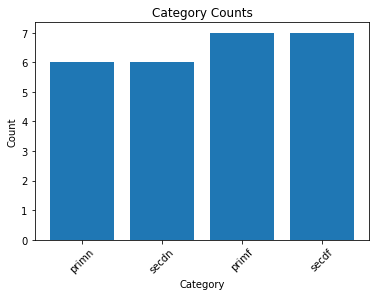

In [19]:
import matplotlib.pyplot as plt

# Extract the category names and counts from the dictionary
categories = list(category_counts.keys())
counts = list(category_counts.values())

# Plot the bar chart
plt.bar(categories, counts)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Category Counts')
plt.xticks(rotation=45)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, time in enumerate([35, 65, 85]):
    selected_year = years[year_indices[time]]

    # Get the habitat counts for the time step
    category_counts = get_category_counts(selected_year)

    # Calculate the percentages
    percentages = 100 * category_counts / sum(category_counts)

    # Plot the bar chart
    ax = axes[i]
    ax.bar(categories, percentages)
    ax.set_xlabel('Category')
    ax.set_ylabel('Percentage')
    ax.set_title('Category Counts (Time Step {})'.format(time))
    ax.set_xticks(rotation=45)

plt.tight_layout()
plt.show()


In [ ]:
# all three timesteps

### by extent

In [27]:
import geopandas as gpd
from shapely.geometry import box

years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050','2052', '2056', '2080', '2100', '2150', '2200', '2250']
year_indices = {35: 9, 65: 12, 85: 13}
selected_year = years[year_indices[time[0]]]
if time[0] == 35 or time[0] == 65:
    GCMs = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    bioscen_GCMs = ['GFDL.ESM2M', 'IPSL.CM5A-LR', 'HadGEM2.ES', 'MIROC5']
    scenarios = ["rcp26","rcp60"]
    ssprcps_shorts = ["ssp126","ssp460"]
elif time[0] == 85:
    GCMs = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    bioscen_GCMs = ['IPSL.CM5A-LR', 'HadGEM2.ES', 'MIROC5']
    scenarios = ["rcp26"]
    ssprcps_shorts = ["ssp126"]
    
species_habitat_counts = {}



for taxa in taxas:   
    for model in models:
        convcodes = pd.read_csv("/storage/homefs/ch21o450/scripts/BioScenComb/data/IUCN_LUH_converion_table_Carlson.csv")
        dir_habclass = "/storage/homefs/ch21o450/IUCN/Habitat_Classifications/" + taxa + "/"
        dir_species = "/storage/workspaces/wa_climate/climate_trt/data/BioScen15/individual_projections/" + taxa+ "_" + model +"_results_climate/"
        available_file = os.listdir(dir_species)
        available_names = [x.split(".csv")[0] for x in available_file]

        formatted_names = []

        for species_name in available_names:
            split_species_name = species_name.split("_")[:2]
            formatted_species_name = " ".join(split_species_name)
            formatted_names.append(formatted_species_name)

        for i, species_name in enumerate(formatted_names):
            formatted_species_name = species_name.replace(" ", "_")
            species_habitat_counts[formatted_species_name] = {f'LUH{i}': 0 for i in range(1,13)}
            

            for file_name in available_file:
                if formatted_species_name in file_name and model + '_dispersal.csv.xz' in file_name:
                    species_file = file_name
                    species_file2 = [x.split(".csv")[0] for x in species_file] 
                    break
            else:
                bioscen_species = None
                continue

            bioscen_species = pd.read_csv(dir_species + file_name)

            available_files_iucn = formatted_species_name + ".csv"
            if available_files_iucn in os.listdir(dir_habclass):
                IUCN = pd.read_csv(dir_habclass + available_files_iucn)
            else:
                continue

            lon = bioscen_species["x"]
            lat = bioscen_species["y"]
            z = bioscen_species[bioscen_GCM + '_' + scenario + '_' + selected_year]

            df = pd.DataFrame({"lon": lon, "lat": lat, "vals": z})
            df = df.fillna(0)
            
            # Create a bounding box geometry for the desired extent
            extent = box(-20, -40, 60, 40)

            # Check if there are values within the extent
            if df[(df['lon'] >= extent.bounds[0]) & (df['lon'] <= extent.bounds[2]) &
               (df['lat'] >= extent.bounds[1]) & (df['lat'] <= extent.bounds[3])].empty:
                # No values within the extent, end the code
                print("No values within the specified extent.")
            else:

                convcodes_renamed = convcodes.rename(columns={'IUCN_hab':'result.code'})
                IUCN['result.code'] = pd.to_numeric(IUCN['result.code'], errors='coerce')
                Habitats = IUCN.merge(convcodes_renamed, left_on='result.code', right_on='result.code')

                keys = ['LUH1', 'LUH2', 'LUH3', 'LUH4', 'LUH5', 'LUH6', 'LUH7', 'LUH8','LUH9','LUH10', 'LUH11', 'LUH12']
                split_cols = Habitats['LUH'].str.split('.', expand=True)
                for i, key in enumerate(keys):
                    if i < len(split_cols.columns):
                        Habitats[key] = split_cols[i]
                    else:
                        Habitats[key] = pd.Series(dtype='float64')
                if len(Habitats.columns) > len(keys) + 1:
                    num_missing_cols = len(Habitats.columns) - len(keys) - 1
                    Habitats = Habitats.reindex(columns=list(Habitats.columns) + ['LUH{}'.format(i) for i in range(13, 13 + num_missing_cols)], fill_value=np.nan)
                Habitats_suitable = Habitats[Habitats['result.suitability'] == 'Suitable'].copy()


                for i in range(1, 13):  # Assuming you have up to LUH20
                    habitat_key = f'LUH{i}'

                    # Check if not all values are NaN
                    if not Habitats_suitable[habitat_key].isnull().all():
                        # Get the unique habitat classes in the column
                        habitats = Habitats_suitable[habitat_key].dropna().unique()

                        # Increment the count for each habitat class
                        for habitat in habitats:
                            if habitat not in species_habitat_counts[formatted_species_name]:
                                species_habitat_counts[formatted_species_name][habitat] = 0
                            species_habitat_counts[formatted_species_name][habitat] += 1
# Initialize a dictionary to hold the counts per category
category_counts = {}

# Iterate over each species' habitat counts
for species, counts in species_habitat_counts.items():
    # Create a set to track unique habitats for the current species
    unique_habitats = set()

    # Iterate over each habitat count for the species
    for habitat, count in counts.items():
        # Check if the habitat starts with 'LUH' and the count is non-zero
        if not habitat.startswith('LUH') and count > 0:
            # Add the habitat to the set
            unique_habitats.add(habitat)
            # Check if the habitat is already in the dictionary
            if habitat not in category_counts:
                category_counts[habitat] = 0
            # Increment the count for the habitat category
            category_counts[habitat] += 1

print(category_counts)

            

No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/Anaconda3/2021.11-foss-2021a/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3172: DtypeWarning: Columns (28,32) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(
/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/Anaconda3/2021.11-foss-2021a/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3172: DtypeWarning: Columns (27,32) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/Anaconda3/2021.11-foss-2021a/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3172: DtypeWarning: Columns (28,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(
/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/Anaconda3/2021.11-foss-2021a/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3172: DtypeWarning: Columns (27,31,87,91) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
{'primn': 1742, 'secdn': 1742, 'primf': 2090, 'secdf': 2124, 'c3ann': 473, 'pastr': 362, 'c3per': 473, 'range': 362, 'c4ann': 473, 'c4per': 473, 'c3nfx': 473, 'urban': 172, 'MARINE': 9}


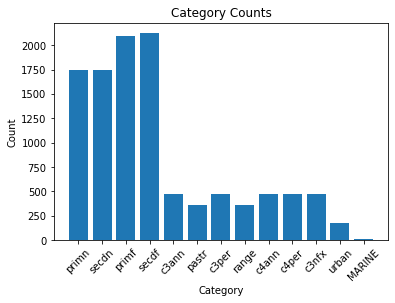

In [28]:
import matplotlib.pyplot as plt

# Extract the category names and counts from the dictionary
categories = list(category_counts.keys())
counts = list(category_counts.values())

# Plot the bar chart
plt.bar(categories, counts)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Category Counts')
plt.xticks(rotation=45)
plt.show()


In [8]:
import regionmask

# Get the abbreviations of the SREX regions
abbrevs = regionmask.defined_regions.srex.abbrevs

# Get the extent of each region
region_extents = regionmask.defined_regions.srex.bounds

# Print the extent of each region
for region_idx, region_name in enumerate(abbrevs):
    extent = region_extents[region_idx]
    print(f"Region {region_name}: Longitude ({extent[0]}, {extent[2]}), Latitude ({extent[1]}, {extent[3]})")


Region ALA: Longitude (-168.022, -105.0), Latitude (60.0, 72.554)
Region CGI: Longitude (-105.0, -10.0), Latitude (50.0, 85.0)
Region WNA: Longitude (-130.0, -105.0), Latitude (28.566, 60.0)
Region CNA: Longitude (-105.0, -85.0), Latitude (28.566, 50.0)
Region ENA: Longitude (-85.0, -60.0), Latitude (25.0, 50.0)
Region CAM: Longitude (-118.323, -68.8), Latitude (-1.239, 28.566)
Region AMZ: Longitude (-79.729, -50.0), Latitude (-20.0, 11.439)
Region NEB: Longitude (-50.0, -34.0), Latitude (-20.0, 0.0)
Region WSA: Longitude (-82.022, -66.377), Latitude (-56.704, 0.53)
Region SSA: Longitude (-72.141, -39.376), Latitude (-56.704, -20.0)
Region NEU: Longitude (-10.0, 40.0), Latitude (48.0, 75.0)
Region CEU: Longitude (-10.0, 40.0), Latitude (45.0, 61.32)
Region MED: Longitude (-10.0, 40.0), Latitude (30.0, 45.0)
Region SAH: Longitude (-20.0, 40.0), Latitude (15.0, 30.0)
Region WAF: Longitude (-20.0, 25.0), Latitude (-11.365, 15.0)
Region EAF: Longitude (25.0, 51.99), Latitude (-11.365, 15.0

In [11]:
import regionmask

# Get the SREX regions
region = regionmask.defined_regions.srex

# Get the extent of each region
region_extents = region.bounds

# Print the extent of each region
for region_idx, region_name in enumerate(region.names):
    extent = region_extents[region_idx]
    print(f"Region {region_name}: ({extent[0]}, {extent[1]}, {extent[2]}, {extent[3]})")


Region Alaska/N.W. Canada: (-168.022, 60.0, -105.0, 72.554)
Region Canada/Greenl./Icel.: (-105.0, 50.0, -10.0, 85.0)
Region W. North America: (-130.0, 28.566, -105.0, 60.0)
Region C. North America: (-105.0, 28.566, -85.0, 50.0)
Region E. North America: (-85.0, 25.0, -60.0, 50.0)
Region Central America/Mexico: (-118.323, -1.239, -68.8, 28.566)
Region Amazon: (-79.729, -20.0, -50.0, 11.439)
Region N.E. Brazil: (-50.0, -20.0, -34.0, 0.0)
Region Coast South America: (-82.022, -56.704, -66.377, 0.53)
Region S.E. South America: (-72.141, -56.704, -39.376, -20.0)
Region N. Europe: (-10.0, 48.0, 40.0, 75.0)
Region C. Europe: (-10.0, 45.0, 40.0, 61.32)
Region S. Europe/Mediterranean: (-10.0, 30.0, 40.0, 45.0)
Region Sahara: (-20.0, 15.0, 40.0, 30.0)
Region W. Africa: (-20.0, -11.365, 25.0, 15.0)
Region E. Africa: (25.0, -11.365, 51.99, 15.0)
Region S. Africa: (-10.0, -35.0, 51.99, -11.365)
Region N. Asia: (40.0, 50.0, 180.0, 70.0)
Region W. Asia: (40.0, 15.0, 60.0, 50.0)
Region C. Asia: (60.0, 

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import numpy as np

# Assuming that da is your xarray.DataArray
da = pop_data_1861_2005

# Define the continental extents
extents = {'North America': [-170, -50, 10, 85],
           'South America': [-90, -30, -60, 15],
           'Europe': [-25, 45, 35, 85],
           'Africa': [-20, 55, -35, 40],
           'Asia': [45, 180, 5, 85],
           'Australia': [113, 154, -44, -10]}

'Alaska/N.W. Canada': [-168.022, 60.0, -105.0, 72.554],
'Canada/Greenl./Icel.': [-105.0, 50.0, -10.0, 85.0],
'W. North America': [-130.0, 28.566, -105.0, 60.0],
'C. North America': [-105.0, 28.566, -85.0, 50.0],
'E. North America': [-85.0, 25.0, -60.0, 50.0],
'Central America/Mexico': [-118.323, -1.239, -68.8, 28.566],
'Amazon': [-79.729, -20.0, -50.0, 11.439],
'N.E. Brazil': [-50.0, -20.0, -34.0, 0.0],
'Coast South America': [-82.022, -56.704, -66.377, 0.53],
'S.E. South America': [-72.141, -56.704, -39.376, -20.0],
'N. Europe': [-10.0, 48.0, 40.0, 75.0],
Region C. Europe: (-10.0, 45.0, 40.0, 61.32)
Region S. Europe/Mediterranean: (-10.0, 30.0, 40.0, 45.0)
Region Sahara: (-20.0, 15.0, 40.0, 30.0)
Region W. Africa: (-20.0, -11.365, 25.0, 15.0)
Region E. Africa: (25.0, -11.365, 51.99, 15.0)
Region S. Africa: (-10.0, -35.0, 51.99, -11.365)
Region N. Asia: (40.0, 50.0, 180.0, 70.0)
Region W. Asia: (40.0, 15.0, 60.0, 50.0)
Region C. Asia: (60.0, 30.0, 75.0, 50.0)
Region Tibetan Plateau: (75.0, 30.0, 100.0, 50.0)
Region E. Asia: (100.0, 20.0, 145.0, 50.0)
Region S. Asia: (60.0, 5.0, 100.0, 30.0)
Region S.E. Asia: (95.0, -10.0, 155.0, 20.0)
Region N. Australia: (110.0, -30.0, 155.0, -10.0)
Region S. Australia/New Zealand: (110.0, -50.0, 180.0, -30.0)

# Loop over each year (note: this will skip the first year, as it has no previous year to compare with)
for year in range(15+15, len(pop_data_1861_2005)-1):
    # Calculate the yearly differences and the relative difference
    diff = ((da[year+1] - da[year])/ da[year]) * 100

    fig, axes = plt.subplots(nrows=6, ncols=1, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 30))

    for row, (continent, extent) in enumerate(extents.items()):
        ax = axes[row]
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        ax.coastlines()

        # Plot the data
        im = diff.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False, cmap='RdBu_r', vmin=-100, vmax=100)

        # Add a colorbar
        cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.03)
        cbar.set_label("Relative difference", size=14)

    fig.tight_layout()

    # Save the figure to a pdf file
    plt.savefig(f'../results/test/{year+1861}_difference.pdf')

    plt.close(fig)
    
    print("Year completed: " + str(year+1861))

# Region Alaska/N.W. Canada: (-168.022, 60.0, -105.0, 72.554)

In [3]:
import geopandas as gpd
from shapely.geometry import box

years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050','2052', '2056', '2080', '2100', '2150', '2200', '2250']
year_indices = {35: 9, 65: 12, 85: 13}
selected_year = years[year_indices[time[0]]]
if time[0] == 35 or time[0] == 65:
    GCMs = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    bioscen_GCMs = ['GFDL.ESM2M', 'IPSL.CM5A-LR', 'HadGEM2.ES', 'MIROC5']
    scenarios = ["rcp26","rcp60"]
    ssprcps_shorts = ["ssp126","ssp460"]
elif time[0] == 85:
    GCMs = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    bioscen_GCMs = ['IPSL.CM5A-LR', 'HadGEM2.ES', 'MIROC5']
    scenarios = ["rcp26"]
    ssprcps_shorts = ["ssp126"]
    
species_habitat_counts = {}

GCM = GCMs[1]
bioscen_GCM = bioscen_GCMs[1]
scenario=scenarios[0]

for taxa in taxas:   
    for model in models:
        convcodes = pd.read_csv("/storage/homefs/ch21o450/scripts/BioScenComb/data/IUCN_LUH_converion_table_Carlson.csv")
        dir_habclass = "/storage/homefs/ch21o450/IUCN/Habitat_Classifications/" + taxa + "/"
        dir_species = "/storage/workspaces/wa_climate/climate_trt/data/BioScen15/individual_projections/" + taxa+ "_" + model +"_results_climate/"
        available_file = os.listdir(dir_species)
        available_names = [x.split(".csv")[0] for x in available_file]

        formatted_names = []

        for species_name in available_names:
            split_species_name = species_name.split("_")[:2]
            formatted_species_name = " ".join(split_species_name)
            formatted_names.append(formatted_species_name)

        for i, species_name in enumerate(formatted_names):
            formatted_species_name = species_name.replace(" ", "_")
            species_habitat_counts[formatted_species_name] = {f'LUH{i}': 0 for i in range(1,13)}


            for file_name in available_file:
                if formatted_species_name in file_name and model + '_dispersal.csv.xz' in file_name:
                    species_file = file_name
                    species_file2 = [x.split(".csv")[0] for x in species_file] 
                    break
            else:
                bioscen_species = None
                continue

            bioscen_species = pd.read_csv(dir_species + file_name)

            available_files_iucn = formatted_species_name + ".csv"
            if available_files_iucn in os.listdir(dir_habclass):
                IUCN = pd.read_csv(dir_habclass + available_files_iucn)
            else:
                continue

            lon = bioscen_species["x"]
            lat = bioscen_species["y"]
            z = bioscen_species[bioscen_GCM + '_' + scenario + '_' + selected_year]

            df = pd.DataFrame({"lon": lon, "lat": lat, "vals": z})
            df = df.fillna(0)

            # Create a bounding box geometry for the desired extent
            extent = box(-168.022, 60.0, -105.0, 72.554)


            # Check if there are values within the extent
            if df[(df['lon'] >= extent.bounds[0]) & (df['lon'] <= extent.bounds[2]) &
               (df['lat'] >= extent.bounds[1]) & (df['lat'] <= extent.bounds[3])].empty:
                # No values within the extent, end the code
                print("No values within the specified extent.")
            else:

                convcodes_renamed = convcodes.rename(columns={'IUCN_hab':'result.code'})
                IUCN['result.code'] = pd.to_numeric(IUCN['result.code'], errors='coerce')
                Habitats = IUCN.merge(convcodes_renamed, left_on='result.code', right_on='result.code')

                keys = ['LUH1', 'LUH2', 'LUH3', 'LUH4', 'LUH5', 'LUH6', 'LUH7', 'LUH8','LUH9','LUH10', 'LUH11', 'LUH12']
                split_cols = Habitats['LUH'].str.split('.', expand=True)
                for i, key in enumerate(keys):
                    if i < len(split_cols.columns):
                        Habitats[key] = split_cols[i]
                    else:
                        Habitats[key] = pd.Series(dtype='float64')
                if len(Habitats.columns) > len(keys) + 1:
                    num_missing_cols = len(Habitats.columns) - len(keys) - 1
                    Habitats = Habitats.reindex(columns=list(Habitats.columns) + ['LUH{}'.format(i) for i in range(13, 13 + num_missing_cols)], fill_value=np.nan)
                Habitats_suitable = Habitats[Habitats['result.suitability'] == 'Suitable'].copy()


                for i in range(1, 13):  # Assuming you have up to LUH20
                    habitat_key = f'LUH{i}'

                    # Check if not all values are NaN
                    if not Habitats_suitable[habitat_key].isnull().all():
                        # Get the unique habitat classes in the column
                        habitats = Habitats_suitable[habitat_key].dropna().unique()

                        # Increment the count for each habitat class
                        for habitat in habitats:
                            if habitat not in species_habitat_counts[formatted_species_name]:
                                species_habitat_counts[formatted_species_name][habitat] = 0
                            species_habitat_counts[formatted_species_name][habitat] += 1
# Initialize a dictionary to hold the counts per category
category_counts = {}

# Iterate over each species' habitat counts
for species, counts in species_habitat_counts.items():
    # Create a set to track unique habitats for the current species
    unique_habitats = set()

    # Iterate over each habitat count for the species
    for habitat, count in counts.items():
        # Check if the habitat starts with 'LUH' and the count is non-zero
        if not habitat.startswith('LUH') and count > 0:
            # Add the habitat to the set
            unique_habitats.add(habitat)
            # Check if the habitat is already in the dictionary
            if habitat not in category_counts:
                category_counts[habitat] = 0
            # Increment the count for the habitat category
            category_counts[habitat] += 1

print(category_counts)


# Convert the dictionary to a DataFrame
df = pd.DataFrame(list(category_counts.items()), columns=['Category', 'Count'])

directory_path = '/storage/homefs/ch21o450/scripts/BioScenComb/habitat_counts/'

# Create a filename string with the variables
filename = f'category_counts_{taxa}_{model}_{GCM}_{scenario}_{time}_ALA.csv'

# Join the directory path and filename
full_path = os.path.join(directory_path, filename)

# Write the DataFrame to a CSV file
df.to_csv(full_path, index=False)



            

No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/Anaconda3/2021.11-foss-2021a/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3172: DtypeWarning: Columns (28,32) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(
/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/Anaconda3/2021.11-foss-2021a/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3172: DtypeWarning: Columns (27,32) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/Anaconda3/2021.11-foss-2021a/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3172: DtypeWarning: Columns (28,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(
/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/Anaconda3/2021.11-foss-2021a/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3172: DtypeWarning: Columns (27,31,87,91) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

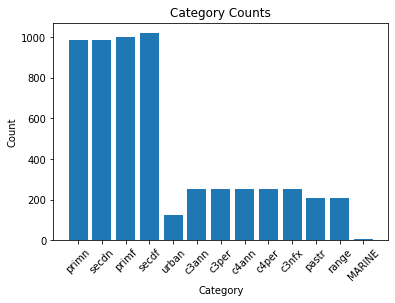

In [4]:
import matplotlib.pyplot as plt
# Read the CSV file into a DataFrame
df = pd.read_csv(full_path)

# Convert each column to a list
categories = df['Category'].tolist()
counts = df['Count'].tolist()

# Extract the category names and counts from the dictionary
categories = list(category_counts.keys())
counts = list(category_counts.values())

# Plot the bar chart
plt.bar(categories, counts)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Category Counts')
plt.xticks(rotation=45)
plt.show()


### Region Canada/Greenl./Icel.: (-105.0, 50.0, -10.0, 85.0)


In [5]:
import geopandas as gpd
from shapely.geometry import box

years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050','2052', '2056', '2080', '2100', '2150', '2200', '2250']
year_indices = {35: 9, 65: 12, 85: 13}
selected_year = years[year_indices[time[0]]]
if time[0] == 35 or time[0] == 65:
    GCMs = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    bioscen_GCMs = ['GFDL.ESM2M', 'IPSL.CM5A-LR', 'HadGEM2.ES', 'MIROC5']
    scenarios = ["rcp26","rcp60"]
    ssprcps_shorts = ["ssp126","ssp460"]
elif time[0] == 85:
    GCMs = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    bioscen_GCMs = ['IPSL.CM5A-LR', 'HadGEM2.ES', 'MIROC5']
    scenarios = ["rcp26"]
    ssprcps_shorts = ["ssp126"]
    
species_habitat_counts = {}

GCM = GCMs[1]
bioscen_GCM = bioscen_GCMs[1]
scenario=scenarios[0]

for taxa in taxas:   
    for model in models:
        convcodes = pd.read_csv("/storage/homefs/ch21o450/scripts/BioScenComb/data/IUCN_LUH_converion_table_Carlson.csv")
        dir_habclass = "/storage/homefs/ch21o450/IUCN/Habitat_Classifications/" + taxa + "/"
        dir_species = "/storage/workspaces/wa_climate/climate_trt/data/BioScen15/individual_projections/" + taxa+ "_" + model +"_results_climate/"
        available_file = os.listdir(dir_species)
        available_names = [x.split(".csv")[0] for x in available_file]

        formatted_names = []

        for species_name in available_names:
            split_species_name = species_name.split("_")[:2]
            formatted_species_name = " ".join(split_species_name)
            formatted_names.append(formatted_species_name)

        for i, species_name in enumerate(formatted_names):
            formatted_species_name = species_name.replace(" ", "_")
            species_habitat_counts[formatted_species_name] = {f'LUH{i}': 0 for i in range(1,13)}


            for file_name in available_file:
                if formatted_species_name in file_name and model + '_dispersal.csv.xz' in file_name:
                    species_file = file_name
                    species_file2 = [x.split(".csv")[0] for x in species_file] 
                    break
            else:
                bioscen_species = None
                continue

            bioscen_species = pd.read_csv(dir_species + file_name)

            available_files_iucn = formatted_species_name + ".csv"
            if available_files_iucn in os.listdir(dir_habclass):
                IUCN = pd.read_csv(dir_habclass + available_files_iucn)
            else:
                continue

            lon = bioscen_species["x"]
            lat = bioscen_species["y"]
            z = bioscen_species[bioscen_GCM + '_' + scenario + '_' + selected_year]

            df = pd.DataFrame({"lon": lon, "lat": lat, "vals": z})
            df = df.fillna(0)

            # Create a bounding box geometry for the desired extent
            extent = box(-105.0, 50.0, -10.0, 85.0)


            # Check if there are values within the extent
            if df[(df['lon'] >= extent.bounds[0]) & (df['lon'] <= extent.bounds[2]) &
               (df['lat'] >= extent.bounds[1]) & (df['lat'] <= extent.bounds[3])].empty:
                # No values within the extent, end the code
                print("No values within the specified extent.")
            else:

                convcodes_renamed = convcodes.rename(columns={'IUCN_hab':'result.code'})
                IUCN['result.code'] = pd.to_numeric(IUCN['result.code'], errors='coerce')
                Habitats = IUCN.merge(convcodes_renamed, left_on='result.code', right_on='result.code')

                keys = ['LUH1', 'LUH2', 'LUH3', 'LUH4', 'LUH5', 'LUH6', 'LUH7', 'LUH8','LUH9','LUH10', 'LUH11', 'LUH12']
                split_cols = Habitats['LUH'].str.split('.', expand=True)
                for i, key in enumerate(keys):
                    if i < len(split_cols.columns):
                        Habitats[key] = split_cols[i]
                    else:
                        Habitats[key] = pd.Series(dtype='float64')
                if len(Habitats.columns) > len(keys) + 1:
                    num_missing_cols = len(Habitats.columns) - len(keys) - 1
                    Habitats = Habitats.reindex(columns=list(Habitats.columns) + ['LUH{}'.format(i) for i in range(13, 13 + num_missing_cols)], fill_value=np.nan)
                Habitats_suitable = Habitats[Habitats['result.suitability'] == 'Suitable'].copy()


                for i in range(1, 13):  # Assuming you have up to LUH20
                    habitat_key = f'LUH{i}'

                    # Check if not all values are NaN
                    if not Habitats_suitable[habitat_key].isnull().all():
                        # Get the unique habitat classes in the column
                        habitats = Habitats_suitable[habitat_key].dropna().unique()

                        # Increment the count for each habitat class
                        for habitat in habitats:
                            if habitat not in species_habitat_counts[formatted_species_name]:
                                species_habitat_counts[formatted_species_name][habitat] = 0
                            species_habitat_counts[formatted_species_name][habitat] += 1
# Initialize a dictionary to hold the counts per category
category_counts = {}

# Iterate over each species' habitat counts
for species, counts in species_habitat_counts.items():
    # Create a set to track unique habitats for the current species
    unique_habitats = set()

    # Iterate over each habitat count for the species
    for habitat, count in counts.items():
        # Check if the habitat starts with 'LUH' and the count is non-zero
        if not habitat.startswith('LUH') and count > 0:
            # Add the habitat to the set
            unique_habitats.add(habitat)
            # Check if the habitat is already in the dictionary
            if habitat not in category_counts:
                category_counts[habitat] = 0
            # Increment the count for the habitat category
            category_counts[habitat] += 1

print(category_counts)


# Convert the dictionary to a DataFrame
df = pd.DataFrame(list(category_counts.items()), columns=['Category', 'Count'])

directory_path = '/storage/homefs/ch21o450/scripts/BioScenComb/habitat_counts/'

# Create a filename string with the variables
filename = f'category_counts_{taxa}_{model}_{GCM}_{scenario}_{time}_GRL.csv'

# Join the directory path and filename
full_path = os.path.join(directory_path, filename)

# Write the DataFrame to a CSV file
df.to_csv(full_path, index=False)



            

No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/Anaconda3/2021.11-foss-2021a/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3172: DtypeWarning: Columns (28,32) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(
/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/Anaconda3/2021.11-foss-2021a/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3172: DtypeWarning: Columns (27,32) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/Anaconda3/2021.11-foss-2021a/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3172: DtypeWarning: Columns (28,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(
/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/Anaconda3/2021.11-foss-2021a/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3172: DtypeWarning: Columns (27,31,87,91) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.


/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

/software.el7/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the specified extent.
No values within the spec

In [ ]:
import matplotlib.pyplot as plt
# Read the CSV file into a DataFrame
df = pd.read_csv(full_path)

# Convert each column to a list
categories = df['Category'].tolist()
counts = df['Count'].tolist()

# Extract the category names and counts from the dictionary
categories = list(category_counts.keys())
counts = list(category_counts.values())

# Plot the bar chart
plt.bar(categories, counts)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Category Counts')
plt.xticks(rotation=45)
plt.show()
